Import modules

In [122]:
import os
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

CPU GPU

In [123]:
# ✅ 使用 GPU (如果有)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


creat path

In [124]:
test_images = glob.glob('cable/test/*/*.png')
train_images = glob.glob('cable/train/good/*.png')
image_paths = train_images + test_images

for path in image_paths:
    try:
        with Image.open(path) as img:
            img.verify()
    except Exception as e:
        print(f"❌ Error in image: {path} → {e}")

Loading data and labeling

In [125]:
base_path = 'cable/test'
class_folders = sorted([d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))])

image_paths = []
labels = []

for idx, class_name in enumerate(class_folders):
    class_dir = os.path.join(base_path, class_name)
    imgs = glob.glob(os.path.join(class_dir, '*.png'))
    image_paths.extend(imgs)
    labels.extend([idx] * len(imgs))

class_to_idx = {name: idx for idx, name in enumerate(class_folders)}
idx_to_class = {v: k for k, v in class_to_idx.items()}

train_x, val_x, train_y, val_y = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42)

print(f"Classes: {class_folders}")
print(f"Total images: {len(image_paths)}")

Classes: ['bent_wire', 'cable_swap', 'combined', 'cut_inner_insulation', 'cut_outer_insulation', 'good', 'missing_cable', 'missing_wire', 'poke_insulation']
Total images: 150


Transform setting

In [126]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.AutoAugment(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

Dataset

In [127]:
class MyDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = torch.tensor(labels).long()
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            img = Image.open(self.image_paths[idx]).convert('RGB')
            if self.transform:
                img = self.transform(img)
            return img, self.labels[idx]
        except Exception as e:
            print(f"[Error] Failed to load: {self.image_paths[idx]} - {e}")
            return self.__getitem__((idx + 1) % len(self.image_paths))

Data loader

In [128]:
batch_size = 16
train_dataset = MyDataset(train_x, train_y, train_transforms)
val_dataset = MyDataset(val_x, val_y, val_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

loss function and model

In [129]:
num_classes = len(class_folders)

model = models.resnet18(weights='IMAGENET1K_V1')
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = CosineAnnealingLR(optimizer, T_max=50)
print(f"{model}")

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

model training

In [ ]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_acc = -1

for epoch in range(50):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = outputs.argmax(1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total * 100
    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            pred = outputs.argmax(1)
            correct += (pred == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total * 100
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_resnet18_multi_class.pth')

    scheduler.step()

    print(f"Epoch {epoch+1}/50, Train loss: {train_losses[-1]:.4f}, Train acc: {train_acc:.2f}%, "
          f"Val loss: {val_losses[-1]:.4f}, Val acc: {val_acc:.2f}%, Best Val acc: {best_val_acc:.2f}%")

Epoch 1/50, Train loss: 2.1511, Train acc: 36.67%, Val loss: 2.0156, Val acc: 40.00%, Best Val acc: 40.00%
Epoch 2/50, Train loss: 1.9560, Train acc: 38.33%, Val loss: 1.9283, Val acc: 40.00%, Best Val acc: 40.00%
Epoch 3/50, Train loss: 1.8806, Train acc: 40.00%, Val loss: 1.8280, Val acc: 46.67%, Best Val acc: 46.67%


visualize training validation curves

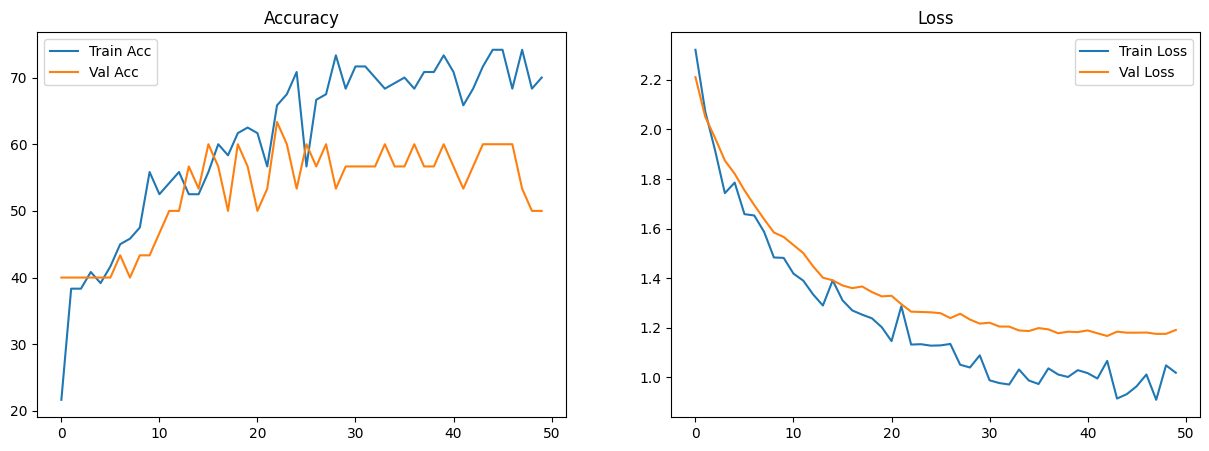

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(train_accuracies, label='Train Acc')
ax[0].plot(val_accuracies, label='Val Acc')
ax[0].set_title('Accuracy')
ax[0].legend()

ax[1].plot(train_losses, label='Train Loss')
ax[1].plot(val_losses, label='Val Loss')
ax[1].set_title('Loss')
ax[1].legend()
plt.show()

Evaluating Your Trained Model

In [ ]:
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        predicted = outputs.argmax(-1)
        print(predicted)
        print(labels)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(f'Test accuracy is {100. * test_correct / test_total:.1f}%')

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([5, 5, 5, 5, 2, 5, 5, 6, 5, 1, 5, 0, 5, 4, 1, 8], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([5, 5, 7, 0, 3, 6, 4, 8, 7, 5, 2, 3, 0, 3], device='cuda:0')
Test accuracy is 10.0%
